In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import nltk.sentiment
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import re
import time

In [80]:
train = pd.read_csv('train_prepped2.csv', index_col = 0)

In [81]:
train

,Title,Genre,Description,clean,lemmatized
ID,,,,,
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...,listening conversation doctor parent 10yearold...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,bus empty student field trip museum natural hi...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,help unemployed father make end meet edith twi...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film ' title refers unrecovered bodies ground ...,film ' title refers unrecovered body ground ze...
...,...,...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,shortlived nbc live sitcom centered bonino wor...,shortlived nbc live sitcom centered bonino wor...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,next generation exploitation sisters kapa bay ...,next generation exploitation sister kapa bay s...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",ze bestaan echt standup comedy growing facing ...,ze bestaan echt standup comedy growing facing ...


In [82]:
def get_wordcount_bar(train):
    '''
    This function takes in the training dataset and creates a bar plot of the
    average wordcount of description based on genre
    '''
    #Make a column on the df for word count
    train['word_count'] = train.lemmatized.str.split().apply(len)
    #Use groupby to get an average length per language
    language_wordcount = train.groupby('Genre').word_count.mean().sort_values(ascending=False)
    #Set style, make a chart
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(figsize=(9, 6))
    ax = sns.barplot(x=language_wordcount.values, 
                 y=language_wordcount.index, palette='Set3')
    plt.title('Average Wordcount of Description by Genre')
    plt.xlabel("Average Word Count")
    plt.ylabel('Genre')
    plt.show()

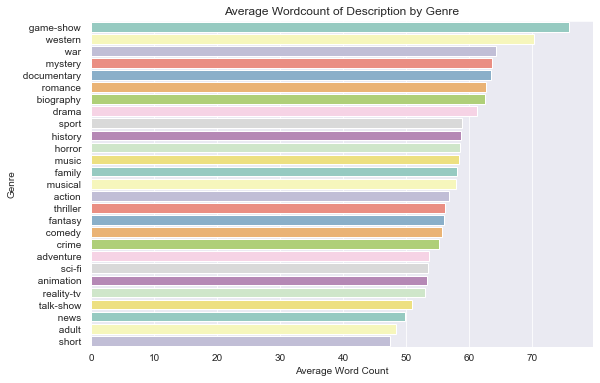

In [83]:
get_wordcount_bar(train)

In [91]:
def get_top10_genre(train, genre):
    '''
    This function takes in a train dataset, creates a df for
    the gameshow genre, then plots the 10 most frequently
    used words in the column labeled 'genre'
    '''
    genre_df = train[train['Genre']== f' {genre} ']
    genre_txt = ' '.join(genre_df['lemmatized'])
    genre_txt = pd.Series(genre_txt.split()).value_counts().head(10).sort_values(ascending=True)
    
    sns.set_style("darkgrid")
    genre_txt.plot.barh(color='#4B8BBE', width=1, figsize=(10, 6))

    plt.title(f'10 Most frequently occuring {genre} strings')
    plt.ylabel('Strings')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = genre_txt.reset_index()['index']
    _ = plt.yticks(ticks, labels)
    
    plt.show()

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  string
 2   Description  54214 non-null  object
 3   clean        54214 non-null  object
 4   lemmatized   54214 non-null  object
 5   word_count   54214 non-null  int64 
dtypes: int64(1), object(4), string(1)
memory usage: 2.9+ MB


In [93]:
train['Genre'] = train.Genre.astype('string')

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  string
 2   Description  54214 non-null  object
 3   clean        54214 non-null  object
 4   lemmatized   54214 non-null  object
 5   word_count   54214 non-null  int64 
dtypes: int64(1), object(4), string(1)
memory usage: 2.9+ MB


In [95]:
train[train.Genre == ' game-show ']

,Title,Genre,Description,clean,lemmatized,word_count
ID,,,,,,
739,"""Picture! Picture!"" (2013)",game-show,The one-hour game show will be hosted by come...,onehour game show hosted comebacking kapuso ac...,onehour game show hosted comebacking kapuso ac...,191
1038,"""Are You Normal, America?"" (2012)",game-show,New game show that will help viewers figure o...,new game show help viewers figure normal ever ...,new game show help viewer figure normal ever p...,65
1506,"""Scrapheap"" (1998)",game-show,"A show in which, each week, two rival teams a...",show week two rival teams given task building ...,show week two rival team given task building k...,29
1686,"""Tien voor taal"" (1990)",game-show,Two teams of usually well-known professionals...,two teams usually wellknown professionals one ...,two team usually wellknown professional one sp...,47
1744,"""It's a Knockout"" (1985)",game-show,"""It's a Knockout"" was a loud, colourful and d...",' knockout loud colourful downright silly game...,' knockout loud colourful downright silly game...,28
...,...,...,...,...,...,...
52665,Spin That Wheel (2011),game-show,This is a game show based around single and m...,game show based around single multi camera tec...,game show based around single multi camera tec...,44
53342,"""3's a Crowd"" (1979)",game-show,"""Who knows a man better his wife or his secre...",knows man better wife secretary chuck barris g...,know man better wife secretary chuck barris ga...,34
53923,"""Jackpot"" (1974)",game-show,"""Jackpot"" featured 16 contestants attempting ...",jackpot featured 16 contestants attempting sol...,jackpot featured 16 contestant attempting solv...,375


In [96]:
train.Genre == ' drama '

ID
1         True
2        False
3        False
4         True
5         True
         ...  
54210    False
54211    False
54212    False
54213    False
54214    False
Name: Genre, Length: 54214, dtype: boolean

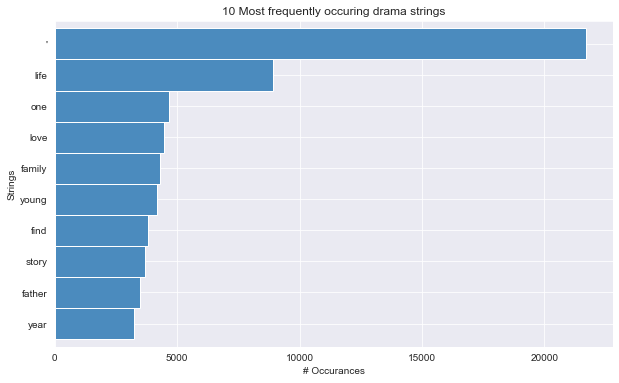

In [97]:
get_top10_genre(train, 'drama')

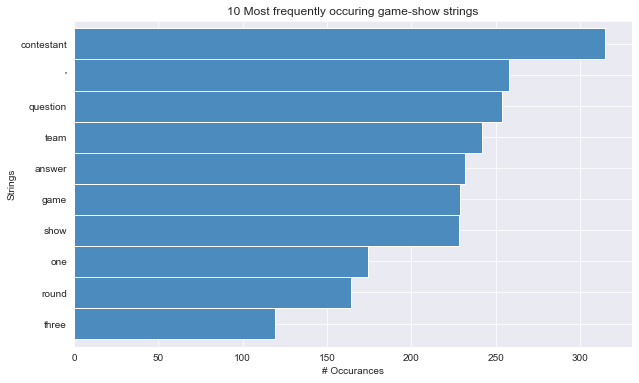

In [98]:
get_top10_genre(train, 'game-show')

In [99]:
genre = 'drama'
genre_df = train[train['Genre']== f' {genre} ']
genre_txt = ' '.join(genre_df['lemmatized'])
genre_txt = pd.Series(genre_txt.split()).value_counts().head(10).sort_values(ascending=True)

genre_txt

year       3253
father     3482
story      3697
find       3815
young      4178
family     4294
love       4472
one        4656
life       8918
'         21708
dtype: int64